In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch

import math
from collections import deque
from torch.distributions import Categorical


In [ ]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import gymnax
from src.luxai_s3.env import LuxAIS3Env
from src.luxai_s3.params import EnvParams, env_params_ranges
from jax_utils import obs_to_state

In [84]:
import jax.numpy as jnp
from jax import jit
from functools import partial

def min_manhattan_dist(matrix):
    h, w = matrix.shape
    inf = h + w  # Upper bound for Manhattan distance

    # Initialize distance matrix: 0 for ones, inf for others
    distances = jnp.where(matrix == 1, 0, inf)

    def update(distances):
        """Perform one iteration of distance propagation."""
        padded = jnp.pad(distances, ((1, 1), (1, 1)), constant_values=inf)
        neighbors = [padded[1:-1, 2:], padded[1:-1, :-2], padded[2:, 1:-1], padded[:-2, 1:-1]]
        new_distances = jnp.minimum(distances, jnp.min(jnp.stack(neighbors), axis=0) + 1)
        return new_distances

    # Iterate multiple times (at most h + w times for full spread)
    def condition(val):
        old_dist, new_dist, _ = val
        return ~jnp.all(old_dist == new_dist)  # Stop when no change

    def body(val):
        old_dist, new_dist, i = val
        updated = update(new_dist)
        return new_dist, updated, i + 1

    _, final_distances, _ = jax.lax.while_loop(condition, body, (distances, update(distances), 0))
    return final_distances

# Example usage
matrix = jnp.zeros((24, 24))
matrix = matrix.at[5, 5].set(1)
matrix = matrix.at[10, 15].set(1)
matrix = matrix.at[20, 3].set(1)

distances = min_manhattan_dist(matrix)
print(distances)

[[10  9  8  7  6  5  6  7  8  9 10 11 12 12 11 10 11 12 13 14 15 16 17 18]
 [ 9  8  7  6  5  4  5  6  7  8  9 10 11 11 10  9 10 11 12 13 14 15 16 17]
 [ 8  7  6  5  4  3  4  5  6  7  8  9 10 10  9  8  9 10 11 12 13 14 15 16]
 [ 7  6  5  4  3  2  3  4  5  6  7  8  9  9  8  7  8  9 10 11 12 13 14 15]
 [ 6  5  4  3  2  1  2  3  4  5  6  7  8  8  7  6  7  8  9 10 11 12 13 14]
 [ 5  4  3  2  1  0  1  2  3  4  5  6  7  7  6  5  6  7  8  9 10 11 12 13]
 [ 6  5  4  3  2  1  2  3  4  5  6  7  7  6  5  4  5  6  7  8  9 10 11 12]
 [ 7  6  5  4  3  2  3  4  5  6  7  7  6  5  4  3  4  5  6  7  8  9 10 11]
 [ 8  7  6  5  4  3  4  5  6  7  7  6  5  4  3  2  3  4  5  6  7  8  9 10]
 [ 9  8  7  6  5  4  5  6  7  7  6  5  4  3  2  1  2  3  4  5  6  7  8  9]
 [10  9  8  7  6  5  6  7  7  6  5  4  3  2  1  0  1  2  3  4  5  6  7  8]
 [11 10  9  8  7  6  7  8  8  7  6  5  4  3  2  1  2  3  4  5  6  7  8  9]
 [11 10  9  8  8  7  8  9  9  8  7  6  5  4  3  2  3  4  5  6  7  8  9 10]
 [10  9  8  7  8  8  9 10

In [85]:
import jax.numpy as jnp
from jax import jit

@jit
def min_manhattan_dist_to_one(matrix, x, y):
    h, w = matrix.shape
    inf = h + w  # Upper bound for Manhattan distance

    # Step 1: Initialize distances (0 for 1s, inf for others)
    distances = jnp.where(matrix == 1, 0, inf)

    # Step 2: Forward pass (top-left to bottom-right)
    for i in range(h):
        for j in range(w):
            if i > 0:
                distances = distances.at[i, j].set(jnp.minimum(distances[i, j], distances[i - 1, j] + 1))
            if j > 0:
                distances = distances.at[i, j].set(jnp.minimum(distances[i, j], distances[i, j - 1] + 1))

    # Step 3: Backward pass (bottom-right to top-left)
    for i in range(h - 1, -1, -1):
        for j in range(w - 1, -1, -1):
            if i < h - 1:
                distances = distances.at[i, j].set(jnp.minimum(distances[i, j], distances[i + 1, j] + 1))
            if j < w - 1:
                distances = distances.at[i, j].set(jnp.minimum(distances[i, j], distances[i, j + 1] + 1))

    # Step 4: Return the minimum distance at (x, y)
    return distances[x, y]

# Example usage
matrix = jnp.zeros((24, 24))
matrix = matrix.at[5, 5].set(1)
matrix = matrix.at[10, 15].set(1)
matrix = matrix.at[20, 3].set(1)

x, y = 12, 12  # Compute the minimum distance from (12,12) to a 1
min_distance = min_manhattan_dist_to_one(matrix, x, y)
print(min_distance)

5


In [37]:
env = LuxAIS3GymEnv(numpy_output=True)
for _ in range(24) :
    obs,_ = env.reset()

    for i in tqdm(range(500)) :
        action = dict(
                    player_0=np.random.randint(0,4,size=(env.env_params.max_units, 3)),
                    player_1=np.random.randint(0,4,size=(env.env_params.max_units, 3))
                )
        obs, reward, terminated, truncated, info = env.step(action)

100%|██████████| 500/500 [00:00<00:00, 911.52it/s]


  0%|          | 0/500 [00:00<?, ?it/s]

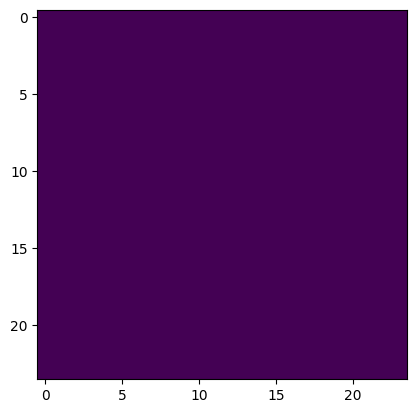

  0%|          | 1/500 [00:02<24:04,  2.89s/it]

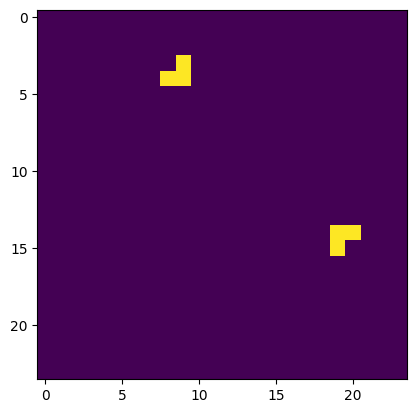

 20%|██        | 101/500 [00:03<00:08, 45.05it/s]

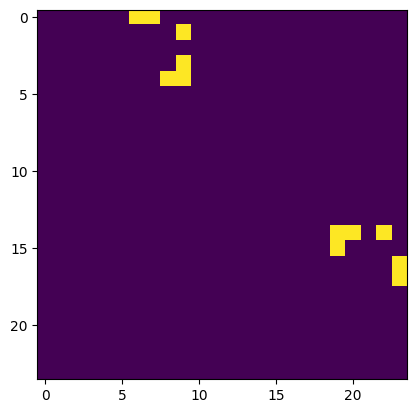

 40%|████      | 201/500 [00:03<00:03, 95.94it/s]

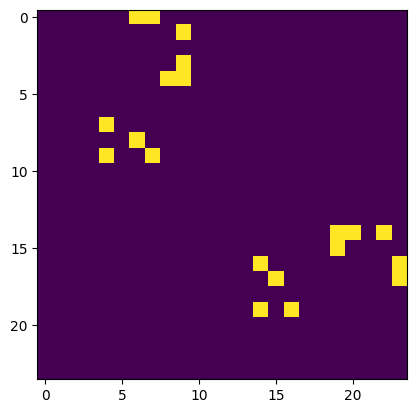

 76%|███████▋  | 382/500 [00:03<00:00, 211.30it/s]

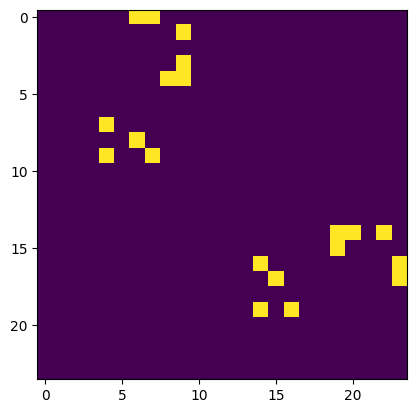

100%|██████████| 500/500 [00:03<00:00, 129.48it/s]


In [ ]:
env = LuxAIS3Env(auto_reset=False)

for _ in range(1) :
    rng_key = jax.random.key(4)

    rng_key, reset_key = jax.random.split(rng_key)
    randomized_game_params = dict()
    for k, v in env_params_ranges.items():
        rng_key, subkey = jax.random.split(rng_key)
        randomized_game_params[k] = jax.random.choice(
            subkey, jax.numpy.array(v)
        ).item()
    params = EnvParams(**randomized_game_params)
    obs,state = env.reset(reset_key, params=params)

    for i in tqdm(range(500)) :
        action = dict(
                    player_0=np.random.randint(0,4,size=(16, 3)),
                    player_1=np.random.randint(0,4,size=(16, 3))
                )
        rng_key, step_key = jax.random.split(rng_key)
        obs, state, reward, terminated, truncated, info = env.step(step_key, state, action, params)

        if i % 100 == 0 :
            plt.imshow(jnp.where(state.relic_nodes_map_weights <= state.relic_nodes_mask.sum()//2,1,0)*jnp.where(state.relic_nodes_map_weights>0,1,0))
            plt.show()

In [8]:
def random_params(rng_key) : 
    randomized_game_params = dict()
    for k, v in env_params_ranges.items():
        rng_key, subkey = jax.random.split(rng_key)
        randomized_game_params[k] = jax.random.choice(
            subkey, jax.numpy.array(v)
        )
    params = EnvParams(**randomized_game_params)
    return params

def generate_random_action(rng_key) :
    action = dict(
                player_0=jax.random.randint(rng_key, (16, 3), 0, 4),
                player_1=jax.random.randint(rng_key, (16, 3), 0, 4)
            )
    return action

rng = jax.random.key(0)
rng, key_reset, key_policy, key_step = jax.random.split(rng, 4)
num_envs = 512

env = LuxAIS3Env(auto_reset=False)

vmap_keys_reset = jax.random.split(key_reset, num_envs)
v_map_random_gen = jax.vmap(random_params, in_axes=0)
env_params = v_map_random_gen(vmap_keys_reset)

In [9]:
vmap_reset = jax.vmap(env.reset, in_axes=(0, 0))
vmap_step = jax.vmap(env.step, in_axes=(0, 0, 0, 0))

vmap_keys = jax.random.split(rng, num_envs)

obs, state = vmap_reset(vmap_keys_reset, env_params)

vmap_keys_step = jax.random.split(key_step, num_envs)

v_map_action = jax.vmap(generate_random_action,in_axes=0)

v_map_obs_to_state = jax.vmap(obs_to_state,in_axes=(0,0,0,0,None))

map_memory = jnp.zeros((num_envs,10, 24, 24), dtype=jnp.float32)
map_memory = map_memory.at[:,5].set(-1)
map_memory = map_memory.at[:,4].set(-1)
map_memory = map_memory.at[:,9].set(-1)

points = jnp.zeros((num_envs,1), dtype=jnp.float32)

for i in tqdm(range(500)) :
    vmap_keys_step = jax.random.split(key_step, num_envs)
    action = v_map_action(vmap_keys_step)

    obs, state, reward, terminated, truncated, info = vmap_step(vmap_keys_step, state, action, env_params)

    if i==0 :
        state_maps, state_features = v_map_obs_to_state(obs,env_params,points,map_memory,'player_0')
    else :
        state_maps, state_features = v_map_obs_to_state(obs,env_params,points,state_maps,'player_0')

  6%|▋         | 32/500 [00:34<08:19,  1.07s/it] 


KeyboardInterrupt: 

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 1 1 0]
  [0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]]]


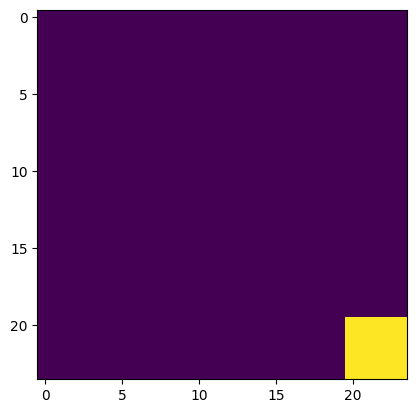

In [ ]:
a = jnp.where(obs['player_0'].sensor_mask,1,0)
b = jnp.flip(a,axis=[-2,-1])
plt.imshow(b)
print(b)

In [2]:
env = LuxAIS3GymEnv(numpy_output=True)
obs,_ = env.reset()

for i in tqdm(range(10)) :
    action = dict(
                player_0=np.random.randint(0,4,size=(env.env_params.max_units, 3)),
                player_1=np.random.randint(0,4,size=(env.env_params.max_units, 3))
            )
    obs, reward, terminated, truncated, info = env.step(action)

print(obs)


100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

{'player_0': {'units': {'position': array([[[ 2,  6],
        [ 1,  2],
        [ 2,  0],
        [ 0,  0],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1]],

       [[-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1]]], dtype=int16), 'energy': array([[ 71,  86,  83, 100,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1],
       [ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1]], dtype=int16)}, 'units_mask': array([[ True,  True,  True,  True, False, False, False, False, False,
        False, False, False, False, False, False, False],
       

In [9]:
a = jax.numpy.array([[[-1,-1],[-1,-1],[-1,-1],[-1,-1]],[[0,1],[2,3],[4,5],[6,7]]])
b =a[::-1,:,::-1]
c = jax.numpy.where(b!=-1)
print(b[c[0],c[1]])

[[1 0]
 [1 0]
 [3 2]
 [3 2]
 [5 4]
 [5 4]
 [7 6]
 [7 6]]
